In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# PCA specific libraries.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Pre-Process AHS to get Only Numbers

I'm going to start by isolating the numerical values in the 2023 AHS dataset.

In [2]:
ahs_2023 = pd.read_feather("../../data/AHS_2023.feather")

In [3]:
ahs_num = ahs_2023.select_dtypes(include=['float64', 'int64'])
ahs_num.columns

Index(['YEAR', 'STORIES', 'YRBUILT', 'RENT', 'UTILAMT', 'HOAAMT', 'INSURAMT',
       'TOTHCAMT', 'UNITFLOORS', 'BATHROOMS', 'BEDROOMS', 'TOTROOMS',
       'KITCHENS', 'DINING', 'LAUNDY', 'FINCP', 'HINCP', 'NUMNONREL',
       'NUMPEOPLE', 'HHADLTKIDS', 'HHAGE', 'HHMOVE', 'RATINGNH'],
      dtype='object')

In [4]:
ahs_num.head(5)

,YEAR,STORIES,YRBUILT,RENT,UTILAMT,HOAAMT,INSURAMT,TOTHCAMT,UNITFLOORS,BATHROOMS,...,DINING,LAUNDY,FINCP,HINCP,NUMNONREL,NUMPEOPLE,HHADLTKIDS,HHAGE,HHMOVE,RATINGNH
0,2023,2,1980,1600,0,-6.0,-6,-6,2,2.5,...,0,0,-6,-6,-6,-6,-6,-6,-6,-6.0
1,2023,2,1970,840,240,-6.0,13,1093,2,1.0,...,0,1,48000,48000,0,3,0,21,2023,6.0
4,2023,7,1920,800,4,-6.0,41,845,1,1.0,...,0,0,36000,36000,0,1,0,64,2019,10.0
6,2023,1,1970,1400,284,-6.0,0,1684,1,1.5,...,0,0,31400,31400,0,1,0,58,2020,10.0
8,2023,3,1950,1600,290,-6.0,13,1903,3,1.5,...,1,1,988000,988000,0,2,0,28,2022,7.0


There are a few variables that need to be removed because they are either irrelevant or are the very thing that we want to predict.

In [5]:
ahs_num.drop(columns=['YEAR', 'RENT', 'FINCP', 'TOTHCAMT'], inplace=True)

Because of the way that the variable BATHROOMS is encoded, the value 4 corresponds to the response "More than three bathrooms." In order for the column to properly be a numeric indicator, we need to drop the observations with value 4.

In [6]:
ahs_num = ahs_num[ahs_num['BATHROOMS'] < 4]
ahs_num.head(5)

,STORIES,YRBUILT,UTILAMT,HOAAMT,INSURAMT,UNITFLOORS,BATHROOMS,BEDROOMS,TOTROOMS,KITCHENS,DINING,LAUNDY,HINCP,NUMNONREL,NUMPEOPLE,HHADLTKIDS,HHAGE,HHMOVE,RATINGNH
0,2,1980,0,-6.0,-6,2,2.5,4,6,1,0,0,-6,-6,-6,-6,-6,-6,-6.0
1,2,1970,240,-6.0,13,2,1.0,2,4,1,0,1,48000,0,3,0,21,2023,6.0
4,7,1920,4,-6.0,41,1,1.0,1,3,1,0,0,36000,0,1,0,64,2019,10.0
6,1,1970,284,-6.0,0,1,1.5,3,5,1,0,0,31400,0,1,0,58,2020,10.0
8,3,1950,290,-6.0,13,3,1.5,3,6,1,1,1,988000,0,2,0,28,2022,7.0


In the variable definitions, the value -6 encodes "Not Applicable". There are some situations in which the value of -6 does not make sense out of context, like the variable HHAGE. However, since the AHS counts vacant units as well, you will find that the variables describing the household will be -6 when no one occupies the unit. We can choose to limit ourselves to occupied units for the purposes of the analysis. First, though, it is a good idea to see how many units we are discarding.

In [7]:
sum(ahs_num['NUMPEOPLE'] == -6)

2908

This is small compared to the total size of the dataset, so we can go ahead and limit to occupied units.

In [8]:
ahs_num = ahs_num[ahs_num['NUMPEOPLE'] != -6]
ahs_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19681 entries, 1 to 55664
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STORIES     19681 non-null  int64  
 1   YRBUILT     19681 non-null  int64  
 2   UTILAMT     19681 non-null  int64  
 3   HOAAMT      19674 non-null  float64
 4   INSURAMT    19681 non-null  int64  
 5   UNITFLOORS  19681 non-null  int64  
 6   BATHROOMS   19681 non-null  float64
 7   BEDROOMS    19681 non-null  int64  
 8   TOTROOMS    19681 non-null  int64  
 9   KITCHENS    19681 non-null  int64  
 10  DINING      19681 non-null  int64  
 11  LAUNDY      19681 non-null  int64  
 12  HINCP       19681 non-null  int64  
 13  NUMNONREL   19681 non-null  int64  
 14  NUMPEOPLE   19681 non-null  int64  
 15  HHADLTKIDS  19681 non-null  int64  
 16  HHAGE       19681 non-null  int64  
 17  HHMOVE      19681 non-null  int64  
 18  RATINGNH    19101 non-null  float64
dtypes: float64(3), int64(16)
memor

Finally, we limit to the number of units that completed the evaluation of their neighborhood.

In [9]:
ahs_num = ahs_num[ahs_num["RATINGNH"] != -6]
ahs_num.replace({"HOAAMT": {-6: 0}}, inplace=True)
ahs_num.dropna(inplace=True)
ahs_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19074 entries, 1 to 55664
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STORIES     19074 non-null  int64  
 1   YRBUILT     19074 non-null  int64  
 2   UTILAMT     19074 non-null  int64  
 3   HOAAMT      19074 non-null  float64
 4   INSURAMT    19074 non-null  int64  
 5   UNITFLOORS  19074 non-null  int64  
 6   BATHROOMS   19074 non-null  float64
 7   BEDROOMS    19074 non-null  int64  
 8   TOTROOMS    19074 non-null  int64  
 9   KITCHENS    19074 non-null  int64  
 10  DINING      19074 non-null  int64  
 11  LAUNDY      19074 non-null  int64  
 12  HINCP       19074 non-null  int64  
 13  NUMNONREL   19074 non-null  int64  
 14  NUMPEOPLE   19074 non-null  int64  
 15  HHADLTKIDS  19074 non-null  int64  
 16  HHAGE       19074 non-null  int64  
 17  HHMOVE      19074 non-null  int64  
 18  RATINGNH    19074 non-null  float64
dtypes: float64(3), int64(16)
memor

In [10]:
ahs_num.head(5)

,STORIES,YRBUILT,UTILAMT,HOAAMT,INSURAMT,UNITFLOORS,BATHROOMS,BEDROOMS,TOTROOMS,KITCHENS,DINING,LAUNDY,HINCP,NUMNONREL,NUMPEOPLE,HHADLTKIDS,HHAGE,HHMOVE,RATINGNH
1,2,1970,240,0.0,13,2,1.0,2,4,1,0,1,48000,0,3,0,21,2023,6.0
4,7,1920,4,0.0,41,1,1.0,1,3,1,0,0,36000,0,1,0,64,2019,10.0
6,1,1970,284,0.0,0,1,1.5,3,5,1,0,0,31400,0,1,0,58,2020,10.0
8,3,1950,290,0.0,13,3,1.5,3,6,1,1,1,988000,0,2,0,28,2022,7.0
10,3,1980,0,0.0,0,1,1.0,1,3,1,0,0,49900,0,1,0,73,2022,7.0


In [11]:
ahs_num.describe()

,STORIES,YRBUILT,UTILAMT,HOAAMT,INSURAMT,UNITFLOORS,BATHROOMS,BEDROOMS,TOTROOMS,KITCHENS,DINING,LAUNDY,HINCP,NUMNONREL,NUMPEOPLE,HHADLTKIDS,HHAGE,HHMOVE,RATINGNH
count,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,1.907400e+04,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000
mean,2.690888,1970.515099,153.173010,0.228321,12.880256,1.425029,1.358682,1.959683,4.335116,0.991664,0.337842,0.143127,6.081704e+04,0.151515,2.110045,0.168869,49.869823,2016.668239,7.719618
std,1.740603,27.376069,140.505919,11.444418,40.124104,0.699083,0.530975,0.969844,1.361744,0.090922,0.496142,0.360829,1.001553e+05,0.457959,1.408381,0.491263,18.027984,7.729673,1.997935
min,1.000000,1919.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-5.000000e+03,0.000000,1.000000,0.000000,15.000000,1947.000000,1.000000
25%,1.000000,1950.000000,60.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,1.450000e+04,0.000000,1.000000,0.000000,34.000000,2015.000000,7.000000
50%,2.000000,1970.000000,120.000000,0.000000,0.000000,1.000000,1.000000,2.000000,4.000000,1.000000,0.000000,0.000000,3.720000e+04,0.000000,2.000000,0.000000,48.000000,2019.000000,8.000000
75%,3.000000,1990.000000,214.000000,0.000000,15.000000,2.000000,2.000000,3.000000,5.000000,1.000000,1.000000,0.000000,7.680000e+04,0.000000,3.000000,0.000000,65.000000,2022.000000,9.000000
max,7.000000,2023.000000,1460.000000,1156.000000,833.000000,3.000000,3.000000,5.000000,13.000000,1.000000,2.000000,2.000000,6.445000e+06,7.000000,15.000000,6.000000,85.000000,2023.000000,10.000000


## Normalize Data to Prep for PCA

After normalization, the result is a data frame of 19 columns and 19074 rows. The data has no missing values and is entirely numeric. This can be passed into the scaler to be stanardized.

In [12]:
# Create and fit the StandardScaler object.
scaler = StandardScaler()
scaler.fit(ahs_num)
# Scale the data.
ahs_scaled = scaler.transform(ahs_num)

## Perform PCA

In [13]:
pca = PCA()
ahs_pca_comps = pca.fit_transform(ahs_scaled)
# Isolate the eigenvectors.
pca_eigen_vecs = pca.components_
# Print dimensions of original data and eigenvector matrix.
print(f"Original data dimensions: {ahs_scaled.shape}")
print(f"Eigenvector matrix dimensions: {pca_eigen_vecs.shape}")

Original data dimensions: (19074, 19)
Eigenvector matrix dimensions: (19, 19)


In [14]:
pca.explained_variance_[:3]

array([4.04309326, 1.61844133, 1.2951935 ])

The above method fits all of the components to get a complete PCA representation of the data. We do this in order to only have to fit the data one time. The resultant transformed data is then stored into the below two arrays.

In [15]:
# Transform to only two components.
ahs_pca_2d = ahs_scaled @ pca_eigen_vecs[:2].T
# Transform to only three components.
ahs_pca_3d = ahs_scaled @ pca_eigen_vecs[:3].T

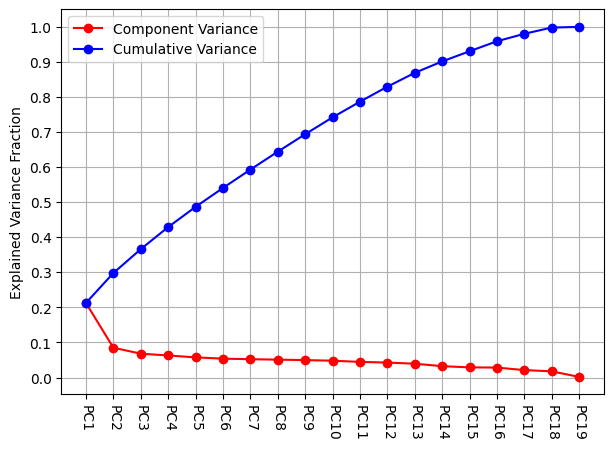

In [16]:
# Store the X and Y values we wish to plot.
cols = [f"PC{i}" for i in range(1, pca_eigen_vecs.shape[0] + 1)]
exp_var = pca.explained_variance_ratio_
# Plot the explained variance of each of the components.
plt.subplots(figsize=[7,5])
plt.plot(cols, exp_var, 'ro', linestyle='solid')
plt.plot(cols, exp_var.cumsum(), 'bo', linestyle='solid')
plt.legend(labels=['Component Variance', 'Cumulative Variance'])
plt.ylabel("Explained Variance Fraction")
plt.yticks(ticks=np.linspace(0, 1, 11))
plt.xticks(rotation=-90)
plt.grid(which='major')

The plot above shows the variance of the individual components as well as the cumulative effect of their inclusion in the dataset. It looks like there isn't a clear subset of dimensions that stand out and explain the majority of the variance observed. On the bright side, there are variables that explain more than would be expected if each of the components was equally important.

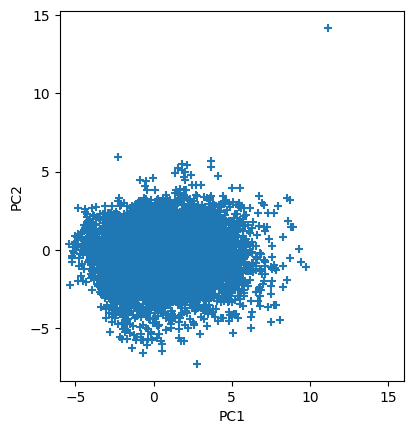

In [20]:
plt.scatter(ahs_pca_2d[:, 0], ahs_pca_2d[:, 1], marker='+')
plt.gca().set_aspect('equal')
plt.xlim(-6, 16)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

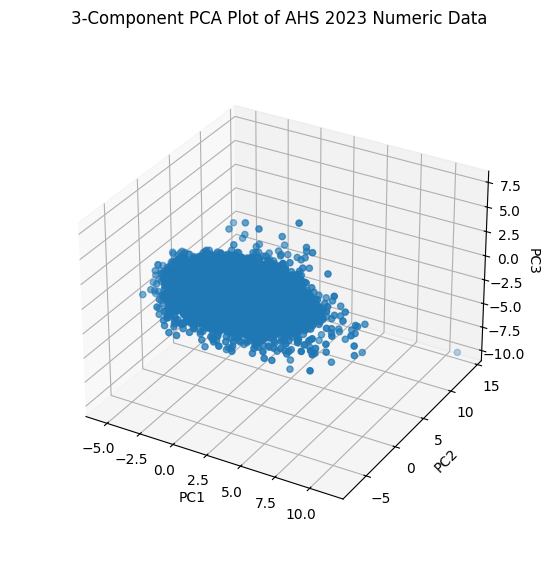

In [21]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.scatter(ahs_pca_3d[:, 0], ahs_pca_3d[:, 1], ahs_pca_3d[:, 2], marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2', rotation=45)
ax.set_zlabel('PC3', rotation=-90)
ax.set_title('3-Component PCA Plot of AHS 2023 Numeric Data')
ax.set_box_aspect(aspect=None, zoom=0.85)
plt.show()

## Trying to Improve the PCA Performance

StandardScaler scales to unit variance and scales so that each column has mean zero, but we still have some columns that are extreme outliers in terms of their data distribution. We can observe this below.

In [22]:
ahs_num.describe()

,STORIES,YRBUILT,UTILAMT,HOAAMT,INSURAMT,UNITFLOORS,BATHROOMS,BEDROOMS,TOTROOMS,KITCHENS,DINING,LAUNDY,HINCP,NUMNONREL,NUMPEOPLE,HHADLTKIDS,HHAGE,HHMOVE,RATINGNH
count,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,1.907400e+04,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000,19074.000000
mean,2.690888,1970.515099,153.173010,0.228321,12.880256,1.425029,1.358682,1.959683,4.335116,0.991664,0.337842,0.143127,6.081704e+04,0.151515,2.110045,0.168869,49.869823,2016.668239,7.719618
std,1.740603,27.376069,140.505919,11.444418,40.124104,0.699083,0.530975,0.969844,1.361744,0.090922,0.496142,0.360829,1.001553e+05,0.457959,1.408381,0.491263,18.027984,7.729673,1.997935
min,1.000000,1919.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-5.000000e+03,0.000000,1.000000,0.000000,15.000000,1947.000000,1.000000
25%,1.000000,1950.000000,60.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,1.450000e+04,0.000000,1.000000,0.000000,34.000000,2015.000000,7.000000
50%,2.000000,1970.000000,120.000000,0.000000,0.000000,1.000000,1.000000,2.000000,4.000000,1.000000,0.000000,0.000000,3.720000e+04,0.000000,2.000000,0.000000,48.000000,2019.000000,8.000000
75%,3.000000,1990.000000,214.000000,0.000000,15.000000,2.000000,2.000000,3.000000,5.000000,1.000000,1.000000,0.000000,7.680000e+04,0.000000,3.000000,0.000000,65.000000,2022.000000,9.000000
max,7.000000,2023.000000,1460.000000,1156.000000,833.000000,3.000000,3.000000,5.000000,13.000000,1.000000,2.000000,2.000000,6.445000e+06,7.000000,15.000000,6.000000,85.000000,2023.000000,10.000000


Some of the columns have very large variances on the top end, others have a massive range of data. When scaling the data we still need to pay attention to columns where the top end number is much larger than the computed standard deviation. Taking a look at the scaled data gives us a sense of where there are problems.

In [23]:
pd.DataFrame(ahs_scaled, columns=ahs_num.columns).describe(percentiles=[]).map(lambda x: f"{x:0.3f}")

,STORIES,YRBUILT,UTILAMT,HOAAMT,INSURAMT,UNITFLOORS,BATHROOMS,BEDROOMS,TOTROOMS,KITCHENS,DINING,LAUNDY,HINCP,NUMNONREL,NUMPEOPLE,HHADLTKIDS,HHAGE,HHMOVE,RATINGNH
count,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000,19074.000
mean,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.971,-1.882,-1.090,-0.020,-0.321,-0.608,-2.559,-2.021,-2.449,-10.907,-0.681,-0.397,-0.657,-0.331,-0.788,-0.344,-1.934,-9.013,-3.363
50%,-0.397,-0.019,-0.236,-0.020,-0.321,-0.608,-0.676,0.042,-0.246,0.092,-0.681,-0.397,-0.236,-0.331,-0.078,-0.344,-0.104,0.302,0.140
max,2.476,1.917,9.301,100.993,20.440,2.253,3.091,3.135,6.363,0.092,3.350,5.146,63.745,14.955,9.153,11.870,1.949,0.819,1.141


The worst offenders are HOAAMT, INSURAMT, and HINCP. We can try and scale these with a logarithmic transformation, then scale.

In [24]:
ahs_num_log = ahs_num.copy()
# Log transform outlier columns.
ahs_num_log = ahs_num_log[ahs_num_log['HINCP'] >= 0]
ahs_num_log['HOAAMT'] = np.log1p(ahs_num_log['HOAAMT'])
ahs_num_log['HINCP'] = np.log1p(ahs_num_log['HINCP'])
ahs_num_log['INSURAMT'] = np.log1p(ahs_num_log['INSURAMT'])
# Scale with Standard Scaler.
scaler_log = StandardScaler()
scaler_log.fit(ahs_num_log)
ahs_scaled_log = scaler_log.transform(ahs_num_log)
# Check new values.
scaled_log_df = pd.DataFrame(ahs_scaled_log, columns=ahs_num_log.columns)
scaled_log_df.describe(percentiles=[0.25, 0.75]).map(lambda x: f"{x:0.3f}")

,STORIES,YRBUILT,UTILAMT,HOAAMT,INSURAMT,UNITFLOORS,BATHROOMS,BEDROOMS,TOTROOMS,KITCHENS,DINING,LAUNDY,HINCP,NUMNONREL,NUMPEOPLE,HHADLTKIDS,HHAGE,HHMOVE,RATINGNH
count,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000,19073.000
mean,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.971,-1.882,-1.090,-0.028,-0.819,-0.608,-2.559,-2.021,-2.449,-10.907,-0.681,-0.397,-4.636,-0.331,-0.788,-0.344,-1.934,-9.013,-3.363
25%,-0.971,-0.749,-0.663,-0.028,-0.819,-0.608,-0.675,-0.990,-0.981,0.092,-0.681,-0.397,-0.229,-0.331,-0.788,-0.344,-0.880,-0.216,-0.360
50%,-0.397,-0.019,-0.236,-0.028,-0.819,-0.608,-0.675,0.042,-0.246,0.092,-0.681,-0.397,0.205,-0.331,-0.078,-0.344,-0.104,0.302,0.140
75%,0.178,0.712,0.433,-0.028,0.942,0.823,1.208,1.073,0.488,0.092,1.335,-0.397,0.538,-0.331,0.632,-0.344,0.839,0.690,0.641
max,2.476,1.917,9.301,47.497,3.453,2.253,3.091,3.135,6.363,0.092,3.350,5.147,2.576,14.954,9.152,11.870,1.949,0.819,1.141


Even with scaling, HOAAMT has much, much higher variance than the rest of the variables. This is because of the high number of zeros in the original column, not necessarily because it has something interesting to tell us. Thus, dropping the HOAAMT column might be the best choice.

In [25]:
scaled_log_df.drop(columns=["HOAAMT"], inplace=True)

In [26]:
pca_log = PCA()
ahs_pca_log_comps = pca_log.fit_transform(scaled_log_df.to_numpy())
# Isolate the eigenvectors.
pca_log_eigen_vecs = pca_log.components_

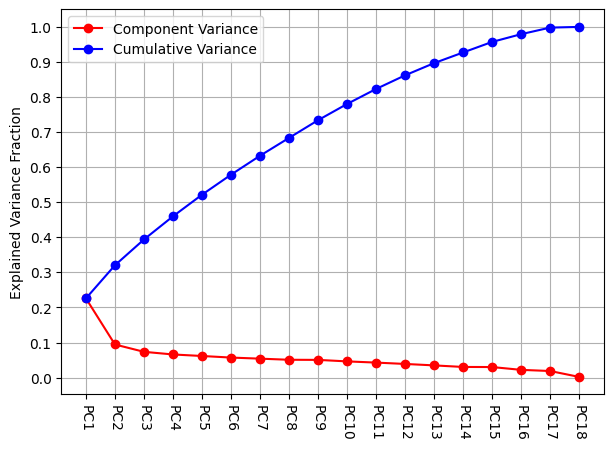

In [27]:
# Store the X and Y values we wish to plot.
cols = [f"PC{i}" for i in range(1, pca_log_eigen_vecs.shape[0] + 1)]
exp_var = pca_log.explained_variance_ratio_
# Plot the explained variance of each of the components.
plt.subplots(figsize=[7,5])
plt.plot(cols, exp_var, 'ro', linestyle='solid')
plt.plot(cols, exp_var.cumsum(), 'bo', linestyle='solid')
plt.legend(labels=['Component Variance', 'Cumulative Variance'])
plt.ylabel("Explained Variance Fraction")
plt.yticks(ticks=np.linspace(0, 1, 11))
plt.xticks(rotation=-90)
plt.grid(which='major')

The result is, disappointingly, practically the same. The first few components do marginally better, you still need most of the dimensions to keep the bulk of the variance.

In [28]:
scaled = scaled_log_df.to_numpy()
# Transform to only two components.
ahs_pca_2d = scaled @ pca_log_eigen_vecs[:2].T
# Transform to only three components.
ahs_pca_3d = scaled @ pca_log_eigen_vecs[:3].T

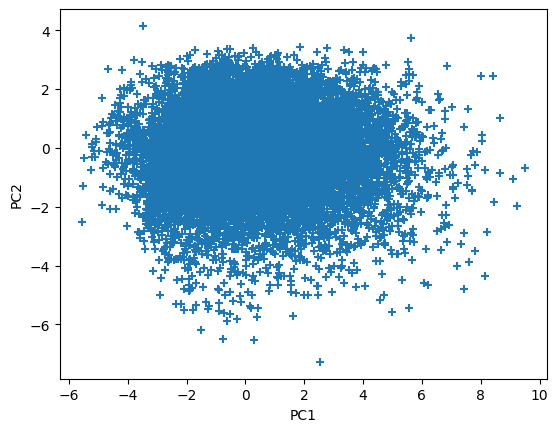

In [33]:
plt.scatter(ahs_pca_2d[:, 0], ahs_pca_2d[:, 1], marker='+')
plt.gca().set_aspect('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

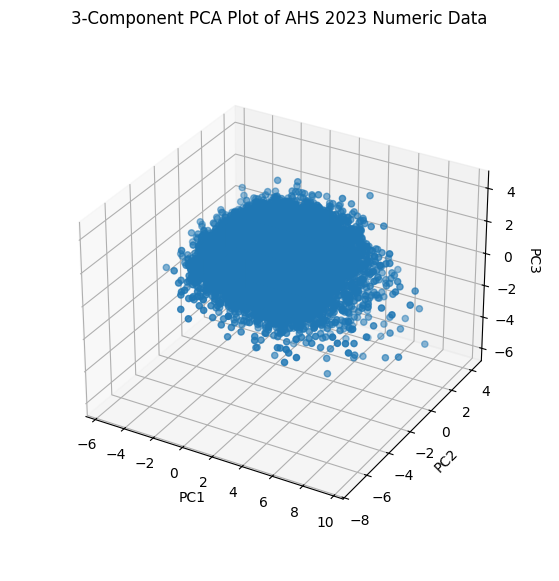

In [86]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.scatter(ahs_pca_3d[:, 0], ahs_pca_3d[:, 1], ahs_pca_3d[:, 2], marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2', rotation=45)
ax.set_zlabel('PC3', rotation=-90)
ax.set_title('3-Component PCA Plot of AHS 2023 Numeric Data')
ax.set_box_aspect(aspect=None, zoom=0.85)
plt.show()